# Phase 3 — VQE for the Heisenberg Spin Chain

Our goal is to use the Variational Quantum Eigensolver (VQE) to estimate
the **ground-state energy** of a small Heisenberg spin chain.

Instead of simulating how the state changes in time, we will:

- Choose a **parameterized circuit** (ansatz) for a trial state $|\psi(\theta)\rangle$,
- Compute its **energy** with respect to the Heisenberg Hamiltonian,
- Use a **classical optimizer** to adjust $\theta$ until the energy is (hopefully) as low as possible.

For a small chain we can still diagonalize the Hamiltonian exactly, so we will compare
our VQE estimate to the exact ground-state energy and then see how things change once
we add noise.

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, SparsePauliOp
from qiskit_aer import AerSimulator

np.random.seed(16)

# Basic model settings
NUM_QUBITS = 4
J_COUPLING = 1.0

def num_params_for_depth(depth, num_qubits=NUM_QUBITS):
    return num_qubits * depth

print(f"Using {NUM_QUBITS}-qubit Heisenberg chain with J = {J_COUPLING}")


Using 4-qubit Heisenberg chain with J = 1.0


## Background

In Phase 3 we use the Variational Quantum Eigensolver (VQE) to estimate the **ground-state
energy** of a Heisenberg spin chain. Instead of simulating time evolution, we prepare a
parameterized trial state $\ket{\psi(\theta)}$ and minimize its energy.

### Heisenberg Hamiltonian

For a 1D chain with nearest-neighbor interactions, the Hamiltonian is

$$
H = J \sum_{\langle i,j \rangle}
\left(
\sigma_i^x \sigma_j^x
+ \sigma_i^y \sigma_j^y
+ \sigma_i^z \sigma_j^z
\right),
$$

where $\sigma_i^\alpha$ is the Pauli matrix $\sigma^\alpha$ acting on qubit (site) $i$.

Each product such as $\sigma_i^x \sigma_j^x$ is a **Pauli string**, and the full Hamiltonian is a sum of these strings.

### Variational principle

Given an ansatz state $\ket{\psi(\theta)}$, its energy is

$$
E(\theta) =
\bra{\psi(\theta)} H \ket{\psi(\theta)}.
$$

Because we can write the Hamiltonian as

$$
H = \sum_k h_k P_k,
$$

the energy becomes

$$
E(\theta) = \sum_k h_k \langle P_k \rangle,
$$

where each expectation value corresponds to a measurable Pauli string.

The variational principle guarantees

$$
E(\theta) \ge E_0,
$$

so minimizing $E(\theta)$ gives an estimate of the ground-state energy.

This notebook will:

- encode the Heisenberg Hamiltonian as Pauli strings,
- build a parameterized ansatz circuit,
- perform VQE optimization,
- compare with exact diagonalization,
- and explore the effect of noise.


## Constructing the Heisenberg Hamiltonian in Qiskit

We now translate the Heisenberg Hamiltonian into a form that Qiskit can work with.

For a 1D chain with nearest-neighbor interactions, the Hamiltonian is

$$
H = J \sum_{\langle i,j \rangle}
\left(
X_i X_j + Y_i Y_j + Z_i Z_j
\right).
$$

To implement this, we loop over all neighboring qubit pairs and add the
corresponding Pauli strings. Qiskit represents these terms using the
`SparsePauliOp` class, which stores each Pauli string and its coefficient.

We start by building a list of `(Pauli string, coefficient)` pairs and then
combine them into a single operator.


In [44]:
from qiskit.quantum_info import SparsePauliOp

def heisenberg_hamiltonian(num_qubits, J=1.0):

    paulis = []
    coeffs = []

    for i in range(num_qubits - 1):
        
        # XX term
        xx = ["I"] * num_qubits
        xx[i] = "X"
        xx[i+1] = "X"
        paulis.append("".join(xx))
        coeffs.append(J)

        # YY term
        yy = ["I"] * num_qubits
        yy[i] = "Y"
        yy[i+1] = "Y"
        paulis.append("".join(yy))
        coeffs.append(J)

        # ZZ term
        zz = ["I"] * num_qubits
        zz[i] = "Z"
        zz[i+1] = "Z"
        paulis.append("".join(zz))
        coeffs.append(J)

    coeffs = np.array(coeffs, dtype=float)

    return SparsePauliOp(paulis, coeffs)


# Build H for the global NUM_QUBITS set earlier
H = heisenberg_hamiltonian(NUM_QUBITS, J=J_COUPLING)

print("Number of terms in Hamiltonian:", len(H.paulis))
print(H)




Number of terms in Hamiltonian: 9
SparsePauliOp(['XXII', 'YYII', 'ZZII', 'IXXI', 'IYYI', 'IZZI', 'IIXX', 'IIYY', 'IIZZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


## Exact Ground-State Energy

VQE is an **approximate** algorithm. For small systems we can still diagonalize the
Hamiltonian matrix directly and find the exact ground-state energy. This gives us a
useful reference to check whether our VQE result makes sense.

Given the Hamiltonian matrix $H$, we solve the eigenvalue problem

$$
H \ket{\psi_n} = E_n \ket{\psi_n},
$$

and sort the eigenvalues $E_n$. The smallest one,

$$
E_{\text{exact}} = \min_n E_n,
$$

is the **exact ground-state energy**, and the corresponding eigenvector is the exact
ground state $\ket{\psi_{\text{gs}}}$.

In this section we:

- convert the `SparsePauliOp` Hamiltonian into a full matrix,
- diagonalize it with NumPy,
- store the exact ground-state energy $E_{\text{exact}}$ for later comparison.


In [45]:
H_matrix = H.to_matrix()

print("Hamiltonian matrix shape:", H_matrix.shape)

# Diagonalize H
eigenvalues, eigenvectors = np.linalg.eigh(H_matrix)

# Extract exact ground-state energy and eigenvector
E_exact = np.min(eigenvalues)
ground_state_index = np.argmin(eigenvalues)
ground_state_exact = eigenvectors[:, ground_state_index]



print("Exact eigenvalues (sorted):")
print(eigenvalues)

print("\nExact ground-state energy E_exact:")
print(E_exact)

Hamiltonian matrix shape: (16, 16)
Exact eigenvalues (sorted):
[-6.46410162 -3.82842712 -3.82842712 -3.82842712 -1.         -1.
 -1.          0.46410162  1.82842712  1.82842712  1.82842712  3.
  3.          3.          3.          3.        ]

Exact ground-state energy E_exact:
-6.464101615137755


## Ansatz Circuit

To run VQE, we need a parameterized circuit $U(\theta)$ that prepares the initial states. The optimizer will adjust these parameters to search for a state with low energy.

A simple and commonly used ansatz for a 1D spin chain is:

1. Apply a single-qubit rotation (e.g., $R_y$) to each qubit,
2. Add CNOTs between neighboring qubits to create entanglement,
3. Repeat this pattern for a small number of layers.

Even a few layers can represent many possible states, and the circuit stays shallow
enough to simulate or run on hardware.

If we choose a depth of $L$ layers and have $N$ qubits, then the ansatz will have
$N \times L$ parameters (one $R_y$ angle per qubit per layer).


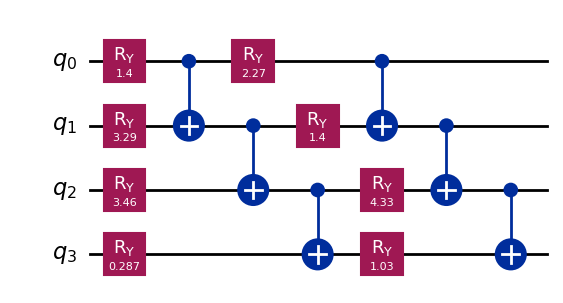

In [46]:
def build_ansatz(num_qubits, depth, params):

    circuit = QuantumCircuit(num_qubits)
    
    # Reshape parameter vector given arguments
    param_matrix = params.reshape((depth, num_qubits))
    
    for layer in range(depth):
        # Ry rotations
        for q in range(num_qubits):
            circuit.ry(param_matrix[layer, q], q)
        
        # Entangling CNOTs between neighbors
        for q in range(num_qubits - 1):
            circuit.cx(q, q + 1)
    
    return circuit


# Example circuit
example_params = np.random.uniform(0, 2*np.pi, NUM_QUBITS * 2)
example_circuit = build_ansatz(NUM_QUBITS, depth=2, params=example_params)
example_circuit.draw("mpl")


## Cost Function

VQE needs a **cost function**: for a given set of parameters $\theta$, we want to compute
the energy

$$
E(\theta) = \bra{\psi(\theta)} H \ket{\psi(\theta)},
$$

where $\ket{\psi(\theta)} = U(\theta) \ket{0 \cdots 0}$ is the state prepared by our ansatz.

In a real experiment, we would estimate $E(\theta)$ by measuring each Pauli string
in the Hamiltonian and averaging over many shots. For now, we keep things simpler and
use the **statevector simulator**:

1. Build the ansatz circuit $U(\theta)$,
2. Use `Statevector` to get the full state $\ket{\psi(\theta)}$,
3. Compute the expectation value with the matrix $H$:

$$
E(\theta) = \psi(\theta)^\dagger \, H \, \psi(\theta).
$$

This gives us a clean, noiseless cost function that we can pass to a classical optimizer.
Later, we will replace this with a **noisy / shot-based** version.


In [47]:
# Choose the ansatz depth
DEPTH = 2

def prepare_state(depth, params):

    params = np.asarray(params, dtype=float)
    
    circuit = build_ansatz(NUM_QUBITS, depth, params)

    state = Statevector.from_instruction(circuit)

    return state

# Cost function: energy expectation value
def energy_expectation(depth, params):

    state = prepare_state(depth, params)

    psi = state.data 
    
    H_psi = H_matrix @ psi
    energy = np.vdot(psi, H_psi)

    return float(np.real(energy))


# Test
theta_test = np.random.uniform(0, 2*np.pi, num_params_for_depth(DEPTH))
E_test = energy_expectation(DEPTH, theta_test)
print("Energy for random parameters:", E_test)


Energy for random parameters: -0.847081300076668


## Noiseless VQE Optimization

With the cost function defined, we can now run VQE in an ideal (noise-free) setting.
The steps are:

1. Initialize the parameter vector $\theta$ randomly,
2. Call a classical optimizer to minimize the energy function,
3. Record the energy at each iteration,
4. Extract the final optimized energy $E_{\text{VQE}}$.

We use the COBYLA optimizer here because it does not require gradients and works well
with small parameter sets. Since we are using the statevector simulator, this run is
fully deterministic and represents the *best possible* performance of our ansatz.


In [48]:
from scipy.optimize import minimize
def run_noiseless_vqe(depth, maxiter=500):
    # Random initial guess
    theta0 = np.random.uniform(0, 2*np.pi, num_params_for_depth(depth))

    energy_history = []

    def cost_fn(theta):
        return energy_expectation(depth, theta)
    
    def callback(theta):    
        E = energy_expectation(depth, theta)
        energy_history.append(E)

    # Run optimization
    optimization_result = minimize(
        cost_fn,
        x0=theta0,
        method="COBYLA",
        callback=callback,
        options={"maxiter": maxiter, "disp": False}
    )

    theta_opt = optimization_result.x
    E_vqe_final = energy_expectation(depth, theta_opt)

    return optimization_result, energy_history, E_vqe_final

## Results: Noiseless VQE vs Exact Ground State

We can now compare the **noiseless VQE result** with the **exact ground-state energy**.

- The exact energy $E_{\text{exact}}$ comes from diagonalizing the full Hamiltonian matrix.
- The VQE energy $E_{\text{VQE}}$ is the minimum value found by COBYLA using our
  depth-2 ansatz.

In an ideal world, if the ansatz could represent the true ground state perfectly and
the optimizer found the global minimum, we would have

$$
E_{\text{VQE}} \approx E_{\text{exact}}.
$$

In practice, for our 4-qubit Heisenberg chain and relatively shallow depth-2 circuit:

- VQE **does lower the energy** significantly compared to random parameters,
- but it **stops well above** the exact ground-state energy.

This tells us that our chosen ansatz is **not expressive enough** to perfectly capture
the true ground state for this model and system size. Later, we will briefly compare
different ansatz depths to see how this affects the final energy.


<<< Noiseless VQE Overview >>>
Number of qubits:           4
Ansatz depth (layers):      2
Exact ground-state energy:  -6.464102
Final VQE energy:           -6.123103
Absolute error:             0.340999
Relative error:             5.28%


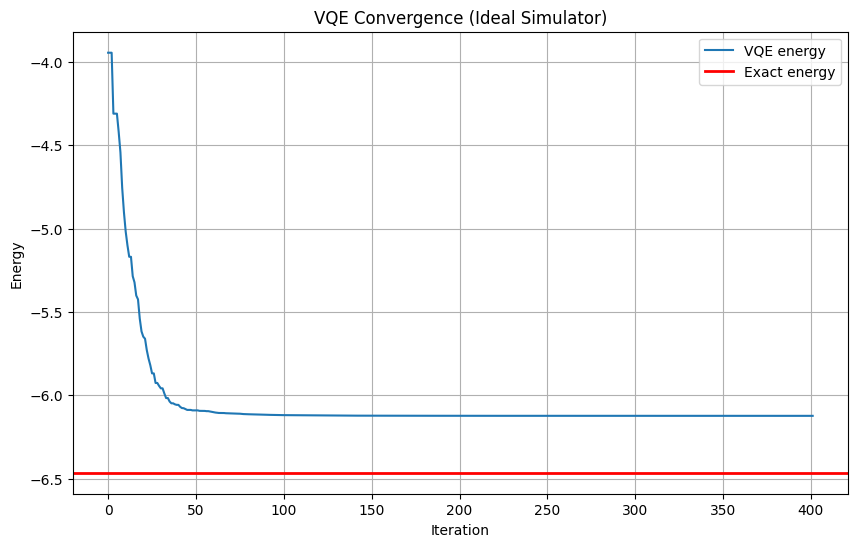

In [49]:
opt_res_ideal, energy_history, E_vqe_final = run_noiseless_vqe(depth=2)

print("<<< Noiseless VQE Overview >>>")
print(f"Number of qubits:           {NUM_QUBITS}")
print(f"Ansatz depth (layers):      {DEPTH}")
print(f"Exact ground-state energy:  {E_exact:.6f}")
print(f"Final VQE energy:           {E_vqe_final:.6f}")

abs_err = abs(E_vqe_final - E_exact)
print(f"Absolute error:             {abs_err:.6f}")

if abs(E_exact) > 1e-8:
    rel_err = abs_err / abs(E_exact)
else:
    rel_err = 0.0  

print(f"Relative error:             {100 * rel_err:.2f}%")

plt.figure(figsize=(10,6))
plt.plot(energy_history, label="VQE energy")
plt.axhline(E_exact, color='r', linewidth=2, label="Exact energy")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("VQE Convergence (Ideal Simulator)")
plt.legend()
plt.grid(True)
plt.show()


## Noisy VQE 

Qiskit provides **fake backends** that mimic real IBM devices. We can:

1. Take a fake backend (with real calibration data),
2. Extract its noise model,
3. Use that noise model in an `AerSimulator`,
4. Run VQE using **shot-based measurements** under this realistic noise.

The rest of the logic is the same: for each Pauli string in $H$, we estimate
its expectation value from bitstring statistics and combine them to get
$$
E(\theta) = \sum_k h_k \langle P_k \rangle.
$$


In [50]:
from qiskit_ibm_runtime.fake_provider import FakeVigoV2
from qiskit_aer.noise import NoiseModel
from qiskit_aer import AerSimulator
from qiskit import transpile

# fake backend with realistic noise
fake_backend = FakeVigoV2()

# Build a noise model from the fake backend
noise_model = NoiseModel.from_backend(fake_backend)
coupling_map = fake_backend.configuration().coupling_map
basis_gates = noise_model.basis_gates

# Noisy simulator backend
noisy_backend = AerSimulator(
    noise_model=noise_model,
    coupling_map=coupling_map,
    basis_gates=basis_gates,
)

print("Using fake backend:", fake_backend.configuration().backend_name)
print("Number of physical qubits:", fake_backend.configuration().n_qubits)
print("Basis gates:", basis_gates)


Using fake backend: fake_vigo
Number of physical qubits: 5
Basis gates: ['cx', 'delay', 'id', 'measure', 'reset', 'rz', 'sx', 'x']


### Estimating a single Pauli string expectation value

To compute the energy, we need expectation values of each Pauli string in the
Hamiltonian. In this cell we:

- convert raw measurement counts into an expectation value $\langle P \rangle$
- build a measurement circuit for a given Pauli string
- apply the correct basis-change gates (for $X$ or $Y$)
- run the circuit on the noisy backend and estimate $\langle P \rangle$ from bitstring (measurement output) statistics


In [51]:
from qiskit import ClassicalRegister

# Hyperparameter (adjustable if desired)
SHOTS = 2000

# We calculate the expectation value of a Pauli string from the count of 
# bitstrings (measurement output)
def pauli_expectation_from_counts(pauli_string, counts):

    total_shots = sum(counts.values())
    if total_shots == 0:
        return 0.0
    
    # So we can adjust number of qubits if desired
    num_qubits = len(pauli_string)
    exp_val = 0.0

    for bitstring, cnt in counts.items():

        value = 1
        # I no influence on eigenvalue
        for q, p in enumerate(pauli_string):
            if p == "I":
                continue

            bit = bitstring[num_qubits - 1 - q]

            z_eigen = 1 if bit == "0" else -1

            value *= z_eigen

        exp_val += (value * cnt)

    return (exp_val / total_shots)

# Uses ansatz circuit and runs on noisy backend. 
# Then estimates expectation value of a Pauli string.
def noisy_expectation_for_pauli(pauli_string, depth, params):

    num_qubits = len(pauli_string)
    
    # ansatz circuit
    qc = build_ansatz(num_qubits, depth, params)

    # needed for measurement
    reg = ClassicalRegister(num_qubits)
    qc.add_register(reg)

    # Basis changes so we can measure in correct basis (Z: ket {0, 1})
    # X: apply H, Y: apply adjoint phase gate + H
    for q, p in enumerate(pauli_string):
        if p == "X":
            qc.h(q)
        elif p == "Y":
            qc.sdg(q)
            qc.h(q)
        

    qc.measure(range(num_qubits), range(num_qubits))

    # Transpile "makes usable circuit"
    transpiled_qc = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=coupling_map,
        optimization_level=0,
    )

    # Run on noisy backend
    job = noisy_backend.run(transpiled_qc, shots=SHOTS)
    result = job.result()
    counts = result.get_counts()

    return pauli_expectation_from_counts(pauli_string, counts)


### Noisy energy cost function

Using the single-Pauli estimator from above, we now construct the full noisy
energy function

$$
E(\theta) = \sum_k h_k \langle P_k \rangle.
$$

For each term $h_k P_k$ in the Heisenberg Hamiltonian, we:

- estimate $\langle P_k \rangle$ using the noisy backend
- multiply by its coefficient $h_k$
- sum everything to obtain the total energy for the current parameters $\theta$

This gives us a noisy version of the same cost function we used in the ideal case.


In [52]:
# Computes sum of all weighted Pauli Strings in the Hamiltonian
def energy_expectation_noisy(depth, params):

    params = np.asarray(params, dtype=float)

    pauli_labels = H.paulis.to_labels()
    coeffs = np.asarray(H.coeffs, dtype=complex)

    energy = 0.0
    for p_str, w in zip(pauli_labels, coeffs):
        exp_p = noisy_expectation_for_pauli(p_str, depth, params)
        energy += float(np.real(w)) * exp_p

    return float(energy)


# Test
theta_test = np.random.uniform(0, 2*np.pi, num_params_for_depth(DEPTH))
E_test_noisy = energy_expectation_noisy(DEPTH, theta_test)
print("Noisy energy estimate for random parameters:", E_test_noisy)


Noisy energy estimate for random parameters: 0.148


### Running noisy VQE

VQE using the **noisy** energy function.

- We start from random parameters $\theta$
- use COBYLA to minimize the noisy energy
- record the energy at each iteration
- and compare the final noisy VQE energy with the ideal VQE result and the exact energy

Because of noise and finite shots, the optimization should be less smooth and 
converge to a higher energy than in the ideal case.


In [53]:
from scipy.optimize import minimize

def run_vqe_noisy(depth, maxiter=60):
    energy_history_noisy = []


    def cost_fn(theta):
        return energy_expectation_noisy(depth, theta)
    # computes energy estimate and appends to history
    def callback_noisy(theta):
        E = energy_expectation_noisy(depth, theta)
        energy_history_noisy.append(E)

    # Random initial parameters
    theta0_noisy = np.random.uniform(0, 2*np.pi, num_params_for_depth(depth))

    # Run optimization
    result_noisy = minimize(
        cost_fn,
        x0=theta0_noisy,
        method="COBYLA",
        callback=callback_noisy,
        options={"maxiter": maxiter, "disp": False}
    )

    # extract optimization results
    theta_opt_noisy = result_noisy.x
    E_vqe_noisy_final = energy_expectation_noisy(depth, theta_opt_noisy)
    return result_noisy, energy_history_noisy, E_vqe_noisy_final

## Comparing Ideal and Noisy VQE

Compare three energies:

- the **exact** ground-state energy
- the **ideal VQE** energy from the statevector simulator,
- the **noisy VQE** energy from the fake backend noise model.

In the ideal case, the cost function is evaluated exactly and cheaply, so we allowed
more optimizer steps. In the noisy case, each evaluation requires many circuit
executions and thousands of shots, so we limited the optimizer to fewer iterations
to reflect realistic hardware constraints.

We expect to see that the noisy VQE outputs a worse approximation of the 
ground-state energy due to the simulation noise and the complexity created by 
requiring multiple circuit executions (shots) per evaluation.

Number of ideal iterations: 402
Number of noisy iterations: 31


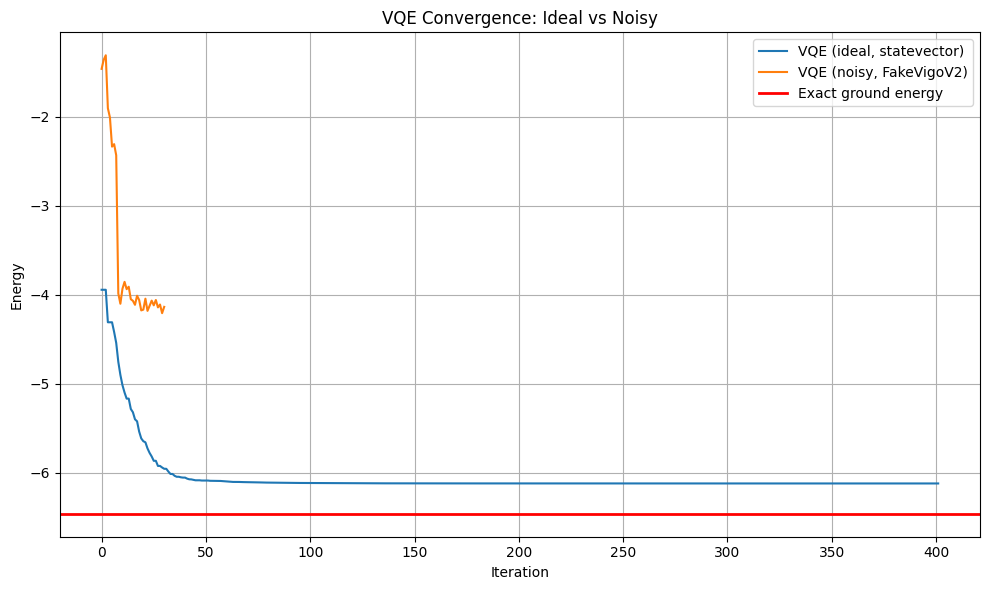

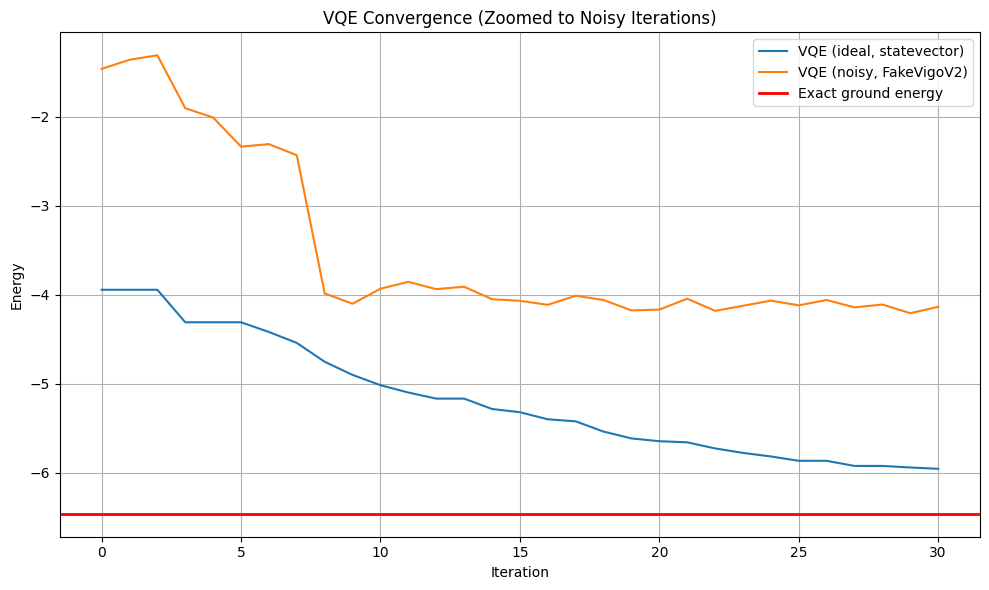


<<< Energy Comparison >>>
Exact ground energy:        -6.464102
Ideal VQE energy (depth 2): -6.123103
Noisy VQE energy:           -4.164000

Absolute error (ideal):     0.340999
Absolute error (noisy):     2.300102
Relative error (ideal):     5.28%
Relative error (noisy):     35.58%


In [55]:
result_noisy, energy_history_noisy, E_vqe_noisy_final = run_vqe_noisy(depth=2, maxiter=60)

print(f"Number of ideal iterations: {len(energy_history)}")
print(f"Number of noisy iterations: {len(energy_history_noisy)}")

plt.figure(figsize=(10, 6))

# Plot ideal VQE curve
plt.plot(energy_history, label="VQE (ideal, statevector)")

# Plot noisy VQE curve
plt.plot(energy_history_noisy, label="VQE (noisy, FakeVigoV2)")

# Exact energy as a horizontal line
plt.axhline(E_exact, color="red", linewidth=2, label="Exact ground energy")

plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("VQE Convergence: Ideal vs Noisy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


iters_ideal = np.arange(len(energy_history))
iters_noisy = np.arange(len(energy_history_noisy))

plt.figure(figsize=(10, 6))

# Only plot ideal for the same number of iterations as noisy
cut = len(energy_history_noisy)
plt.plot(iters_ideal[:cut], energy_history[:cut],
         label="VQE (ideal, statevector)")

plt.plot(iters_noisy, energy_history_noisy,
         label="VQE (noisy, FakeVigoV2)")

plt.axhline(E_exact, color="red", linewidth=2, label="Exact ground energy")

plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("VQE Convergence (Zoomed to Noisy Iterations)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


print("\n<<< Energy Comparison >>>")
print(f"Exact ground energy:        {E_exact:.6f}")
print(f"Ideal VQE energy (depth 2): {E_vqe_final:.6f}")
print(f"Noisy VQE energy:           {E_vqe_noisy_final:.6f}")

err_ideal = abs(E_vqe_final - E_exact)
err_noisy = abs(E_vqe_noisy_final - E_exact)

print(f"\nAbsolute error (ideal):     {err_ideal:.6f}")
print(f"Absolute error (noisy):     {err_noisy:.6f}")

if abs(E_exact) > 1e-8:
    print(f"Relative error (ideal):     {100 * err_ideal / abs(E_exact):.2f}%")
    print(f"Relative error (noisy):     {100 * err_noisy / abs(E_exact):.2f}%")


## Comparing Ansatz Depths

To understand how ansatz expressiveness and noise interact, we compare
ansatz depths and measure the final VQE energy for depths of $1$, $2$, and $3$.

We will run this comparison for both the ideal and noisy VQE implementations.


<<< Noiseless VQE Overview (depth = 1) >>>
Number of qubits:           4
Ansatz depth (layers):      1
Exact ground-state energy:  -6.464102
Final VQE energy:           -3.500001
Absolute error:             2.964100
Relative error:             45.85%

<<< Noiseless VQE Overview (depth = 2) >>>
Number of qubits:           4
Ansatz depth (layers):      2
Exact ground-state energy:  -6.464102
Final VQE energy:           -6.123073
Absolute error:             0.341028
Relative error:             5.28%

<<< Noiseless VQE Overview (depth = 3) >>>
Number of qubits:           4
Ansatz depth (layers):      3
Exact ground-state energy:  -6.464102
Final VQE energy:           -6.462628
Absolute error:             0.001473
Relative error:             0.02%


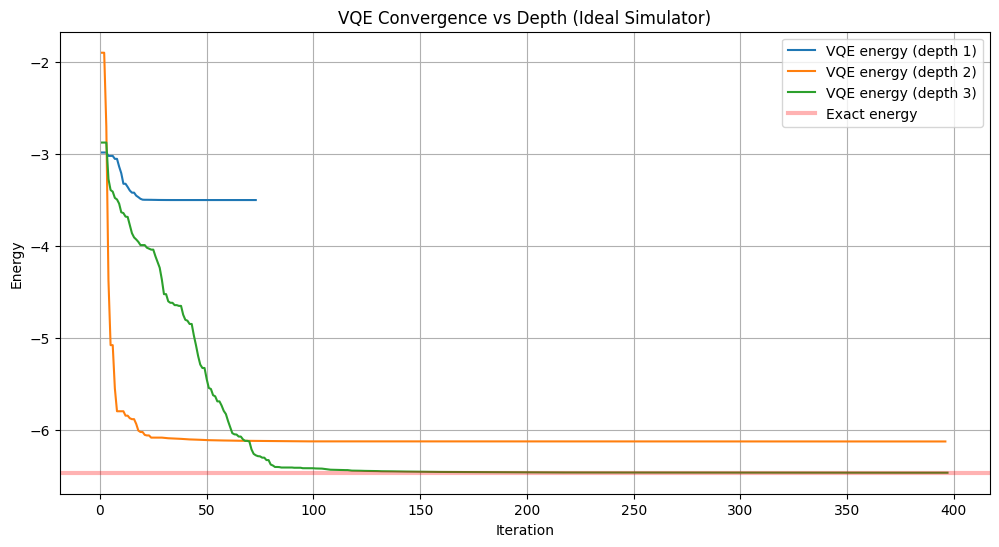

In [ ]:
depths = [1, 2, 3]

energy_histories = {}
final_energies = {}

for d in depths:
    opt_res_ideal, energy_history, E_vqe_final = run_noiseless_vqe(depth=d)
    energy_histories[d] = energy_history
    final_energies[d] = E_vqe_final

    print(f"\n<<< Noiseless VQE Overview (depth = {d}) >>>")
    print(f"Number of qubits:           {NUM_QUBITS}")
    print(f"Ansatz depth (layers):      {d}")
    print(f"Exact ground-state energy:  {E_exact:.6f}")
    print(f"Final VQE energy:           {E_vqe_final:.6f}")

    abs_err = abs(E_vqe_final - E_exact)
    print(f"Absolute error:             {abs_err:.6f}")

    if abs(E_exact) > 1e-8:
        rel_err = abs_err / abs(E_exact)
    else:
        rel_err = 0.0  

    print(f"Relative error:             {100 * rel_err:.2f}%")




plt.figure(figsize=(12, 6))

for d in depths:
    hist = energy_histories[d]
    iters = range(1, len(hist) + 1)
    plt.plot(iters, hist, label=f"VQE energy (depth {d})")

plt.axhline(E_exact, color="red", alpha=0.3, linewidth=3, label="Exact energy")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("VQE Convergence vs Depth (Ideal Simulator)")
plt.legend()
plt.grid(True)
plt.show()



<<< Noisy VQE Overview (depth = 1) >>>
Number of qubits:           4
Ansatz depth (layers):      1
Exact ground-state energy:  -6.464102
Final noisy VQE energy:     -4.419000
Absolute error:             2.045102
Relative error:             31.64%

<<< Noisy VQE Overview (depth = 2) >>>
Number of qubits:           4
Ansatz depth (layers):      2
Exact ground-state energy:  -6.464102
Final noisy VQE energy:     -4.132000
Absolute error:             2.332102
Relative error:             36.08%

<<< Noisy VQE Overview (depth = 3) >>>
Number of qubits:           4
Ansatz depth (layers):      3
Exact ground-state energy:  -6.464102
Final noisy VQE energy:     -4.540000
Absolute error:             1.924102
Relative error:             29.77%


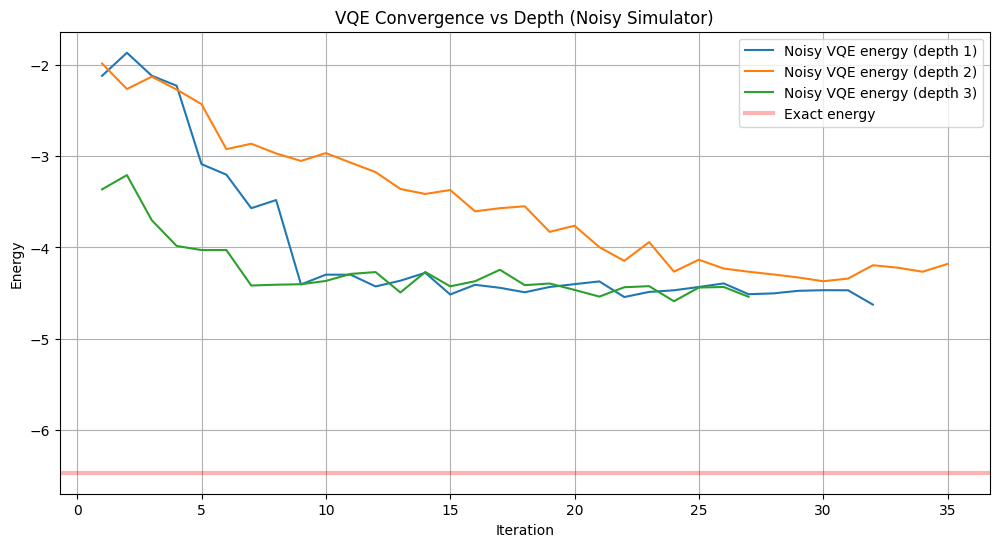

In [ ]:
depths = [1, 2, 3]

energy_histories_noisy = {}
final_energies_noisy = {}

for d in depths:
    opt_res_noisy, energy_history_noisy, E_vqe_noisy_final = run_vqe_noisy(depth=d)
    energy_histories_noisy[d] = energy_history_noisy
    final_energies_noisy[d] = E_vqe_noisy_final

    print(f"\n<<< Noisy VQE Overview (depth = {d}) >>>")
    print(f"Number of qubits:           {NUM_QUBITS}")
    print(f"Ansatz depth (layers):      {d}")
    print(f"Exact ground-state energy:  {E_exact:.6f}")
    print(f"Final noisy VQE energy:     {E_vqe_noisy_final:.6f}")

    abs_err = abs(E_vqe_noisy_final - E_exact)
    print(f"Absolute error:             {abs_err:.6f}")

    if abs(E_exact) > 1e-8:
        rel_err = abs_err / abs(E_exact)
    else:
        rel_err = 0.0  

    print(f"Relative error:             {100 * rel_err:.2f}%")


plt.figure(figsize=(12, 6))

for d in depths:
    hist = energy_histories_noisy[d]
    iters = range(1, len(hist) + 1)
    plt.plot(iters, hist, label=f"Noisy VQE energy (depth {d})")

plt.axhline(E_exact, color="red", alpha=0.3, linewidth=3, label="Exact energy")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("VQE Convergence vs Depth (Noisy Simulator)")
plt.legend()
plt.grid(True)
plt.show()


### Analysis of VQE Performance Across Ansatz Depth (Noiseless vs. Noisy)

To understand how circuit depth affects VQE performance, we evaluated ansatz depths of **1**, **2**, and **3** on a 4-qubit Heisenberg Hamiltonian. Increasing depth adds more layers of single-qubit rotations and entangling gates, which improves the expressive power of the ansatz but also introduces challenges related to optimization and noise.

Below we summarize insights from both the **ideal (statevector)** simulator and our **noisy** simulation.

---

### 1. Noiseless Results: Expressiveness and Optimization
| Depth | Final Energy | Absolute Error | Relative Error |
|-------|--------------|----------------|----------------|
| 1 | −3.5000 | 2.9641 | 45.85% |
| 2 | −6.1231 | 0.3410 | 5.28% |
| 3 | −6.4626 | 0.0015 | 0.02% |

In the ideal simulator, we clearly see the intended behavior of deeper VQE circuits:

- **Depth 1** is too shallow to represent the true ground state.  
  Its ansatz cannot generate the necessary entanglement patterns, so optimization cannot reach a low-energy configuration.

- **Depth 2** shows a major improvement.  
  The additional layer increases the expressiveness enough to approximate the correlated structure of the Heisenberg ground state.

- **Depth 3** nearly matches the exact ground energy (error ∼ 0.02%).  
  This indicates that, for this 4-qubit system, depth 3 provides enough expressive capacity to effectively represent the true ground state.

These results highlight that a deeper ansatz can represent more complex quantum states, 
but only if the optimizer can find good parameters.

In our ideal runs, the optimizer successfully navigated the energy landscape for depths 2 and 3.

---

### 2. Noisy Results: Depth vs. Noise Accumulation
| Depth | Final Noisy Energy | Absolute Error | Relative Error |
|-------|---------------------|----------------|----------------|
| 1 | −4.4190 | 2.0451 | 31.64% |
| 2 | −4.1320 | 2.3321 | 36.08% |
| 3 | −4.5400 | 1.9241 | 29.77% |

- Increasing depth does *not* necessarily improve accuracy.
- Depth 2 actually performs worse than depth 1.
- Depth 3 slightly improves again, but still remains far from the exact energy.

This pattern reflects Deeper circuits are more expressive but also accumulate more noise, which can overpower the benefits of additional layers.

In noisy conditions:

- Each added layer includes more two-qubit gates, which carry the highest error rates.
- Sampling noise affects expectation value estimation.
- Noise distorts the energy landscape itself, making optimization harder and less reliable.

Even if the deeper ansatz *could* represent the ground state, the noisy simulation prevents the optimizer from reaching it.

---

### 3. Optimization Limitations and Local Minima
Both ideal and noisy VQE rely on classical optimization (COBYLA in our case), which has inherent limitations:

- Stops at local minima
- The energy landscape becomes **more complex** with depth: more parameters and saddle points means more chances to get stuck.

This explains why there is variance in final energies across multiple runs with different random initializations, and why simplier ansatz depths sometimes outperform deeper ones.

## VQE Variance

In this section we look at how **unstable** the noisy VQE energy estimate is.

On real hardware (or realistic noisy simulators), repeating the same experiment
does not give exactly the same energy every time. The estimate fluctuates due to:

- random initialization of parameters,
- noise-distorted cost landscape,
- optimizer instability.

To capture the **true spread** of noisy VQE performance, we run the *entire noisy
VQE optimization* multiple times (each with a new random initialization) and store
the **final optimized energy from each run**.


In [ ]:
depth = 2
samples = 30 # takes some time to run (~ 33 minutes)

final_noisy_energies = []

print(f"Running {samples} independent noisy VQE optimizations (depth={depth})...\n")

for i in range(samples):
    _, _, E_final = run_vqe_noisy(depth=depth, maxiter=60)
    final_noisy_energies.append(E_final)
    print(f"Run {i+1:2d}: final energy = {E_final:.6f}")

final_noisy_energies = np.array(final_noisy_energies)

E_mean = float(np.mean(final_noisy_energies))
E_std = float(np.std(final_noisy_energies, ddof=1))

Running 30 independent noisy VQE optimizations (depth=2)...

Run  1: final energy = -4.589000
Run  2: final energy = -4.446000
Run  3: final energy = -4.576000
Run  4: final energy = -2.455000
Run  5: final energy = -4.733000
Run  6: final energy = -3.810000
Run  7: final energy = -4.351000
Run  8: final energy = -4.667000
Run  9: final energy = -2.727000
Run 10: final energy = -2.119000
Run 11: final energy = -4.094000
Run 12: final energy = -3.624000
Run 13: final energy = -3.198000
Run 14: final energy = -2.952000
Run 15: final energy = -4.503000
Run 16: final energy = -3.182000
Run 17: final energy = -4.251000
Run 18: final energy = -3.833000
Run 19: final energy = -2.941000
Run 20: final energy = -4.772000
Run 21: final energy = -4.582000
Run 22: final energy = -4.659000
Run 23: final energy = -2.191000
Run 24: final energy = -3.105000
Run 25: final energy = -4.319000
Run 26: final energy = -2.979000
Run 27: final energy = -2.965000
Run 28: final energy = -3.257000
Run 29: final e


<<< VQE Output Variance Across Multiple Full Runs >>>
Depth:                        2
Independent runs:             30
Mean final noisy energy:      -3.714267
Std dev across runs:          0.820101


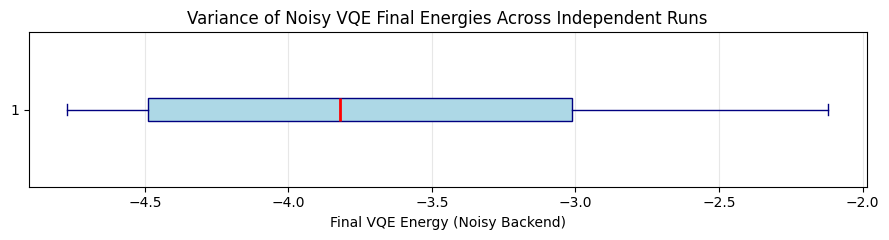

In [ ]:
print("\n<<< VQE Output Variance Across Multiple Full Runs >>>")
print(f"Depth:                        {depth}")
print(f"Independent runs:             {samples}")
print(f"Mean final noisy energy:      {E_mean:.6f}")
print(f"Std dev across runs:          {E_std:.6f}")

plt.figure(figsize=(9, 2.5))
plt.boxplot(final_noisy_energies, vert=False,
            patch_artist=True,
            boxprops=dict(facecolor="lightblue", color="navy"),
            medianprops=dict(color="red", linewidth=2),
            whiskerprops=dict(color="navy"),
            capprops=dict(color="navy"))

plt.xlabel("Final VQE Energy (Noisy Backend)")
plt.title("Variance of Noisy VQE Final Energies Across Independent Runs")
plt.grid(True, axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

### Interpretation of Noisy VQE Variance Across Independent Runs

Running the noisy VQE **30 times** (depth $2$) produced final energies spanning
from about $-4.77$ to $-2.11$, with a mean of $-3.71$ and a standard deviation
of approximately $0.82$. This wide spread shows that the noisy VQE procedure is
**highly sensitive to random initialization and noise during optimization**.

Because each run starts from a different random parameter vector and evaluates a
noisy cost function, the optimizer frequently converges to **different local
minima**. The energy landscape under noise becomes distorted, making
the classical optimizer unreliable. As a result:

- Some runs find relatively low energies (around $-4.6$),
- Many runs get stuck in much higher-energy regions (around $-3$ or above).

#### **Key takeaway**
Under realistic noise, VQE does not produce stable or consistent results across 
runs. The dominant source of variability is the **optimizer interacting with a noisy,
non-smooth energy landscape**, not the circuit depth or ansatz design itself.
This illustrates why VQE on noisy hardware requires error mitigation,
higher shot counts, or more robust optimization strategies to achieve reliable
performance.


## Phase 3 Summary — VQE for the Heisenberg Chain

In this notebook we used VQE to estimate the ground-state energy of a
4-qubit Heisenberg spin chain. We first built the Hamiltonian as a sum of
Pauli strings and diagonalized it to obtain the exact ground-state energy
$E_{\text{exact}}$.

Using a shallow $R_y$ + CNOT ansatz, we ran VQE on an ideal statevector
simulator and saw that:

- Depth $1$ is too shallow and gives a large error.
- Depth $2$ gets much closer to $E_{\text{exact}}$.
- Depth $3$ almost matches the exact ground-state energy, showing that a
slightly deeper ansatz is expressive enough for this 4-qubit model.

We then repeated VQE with a realistic noise model (FakeVigoV2) and
shot-based measurements. In this noisy setting the best energies stayed
well above $E_{\text{exact}}$, and increasing depth did **not** reliably
improve the result because extra layers also introduce more noisy
two-qubit gates.

Finally, by running the noisy VQE $30$ times, we found a wide spread of
final energies (roughly from $-4.77$ to $-2.11$). This shows that, under
noise, VQE can be very sensitive to random initialization and the noisy
energy landscape: different runs converge to different local minima.

Overall, Phase 3 connects the earlier phases to a realistic ground-state
algorithm: we combine Hamiltonians written in Pauli form (Phase 1),
multi-qubit interactions and noise (Phase 2), and see how VQE behaves in
both ideal and noisy conditions for a small Heisenberg spin chain.


## Hardware Experiment Overview

To check how our noisy-VQE result behaves on a real device, we take the
optimized parameters from the noisy simulator and evaluate the energy on an
IBM backend. The goal isn’t to re-optimize on hardware, but simply to see
how a real quantum processor measures the same circuit and how those values
compare to the exact, ideal, and noisy-simulated results. This gives us a
baseline sense of how hardware noise, limited shots, and device variability
affect the final energy estimate.


In [ ]:
# Connect to IBM Quantum and list available hardware backends
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()

print("Hardware backends:")
for backend in service.backends(simulator=False):
    print(" -", backend.name)

qiskit_runtime_service.__init__:WARNING:2025-12-07 20:53:11,537: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2025-12-07 20:53:11,538: Loading instance: open-instance, plan: open


Hardware backends:
 - ibm_fez
 - ibm_torino
 - ibm_marrakesh


In [ ]:
# Choose a specific backend
backend = service.backend("ibm_fez")
print("\nUsing backend:", backend.name)

qiskit_runtime_service.backends:WARNING:2025-12-07 20:53:22,792: Using instance: open-instance, plan: open



Using backend: ibm_fez


In [ ]:
from qiskit import ClassicalRegister, transpile
from qiskit_ibm_runtime import SamplerV2 as Sampler


HARDWARE_DEPTH = 2
HARDWARE_SHOTS = 1000

# Pauli labels and coefficients for the Hamiltonian
hw_pauli_labels = H.paulis.to_labels()
coeffs_array = np.asarray(H.coeffs, dtype=np.complex128)
hw_coeffs = coeffs_array.real.astype(float)


def hardware_expectation_for_pauli(pauli_string, params, backend, shots=HARDWARE_SHOTS):

    num_qubits = len(pauli_string)

    # Build ansatz for the given parameters
    qc = build_ansatz(num_qubits, HARDWARE_DEPTH, params)

    
    reg = ClassicalRegister(num_qubits, "c")
    qc.add_register(reg)

    # Basis changes for X/Y so that we can measure in Z-basis
    for q, p in enumerate(pauli_string):
        if p == "X":
            qc.h(q)
        elif p == "Y":
            qc.sdg(q)
            qc.h(q)
        elif p in ("Z", "I"):
            pass
        else:
            raise ValueError(f"Unknown Pauli symbol {p!r} in {pauli_string!r}")

    qc.measure(range(num_qubits), range(num_qubits))

    # Transpile for the target backend
    transpiled_qc = transpile(qc, backend=backend, optimization_level=1)

    # Run on hardware
    sampler = Sampler(backend)
    job = sampler.run([transpiled_qc], shots=shots)
    result = job.result()

    pub_result = result[0]
    counts = pub_result.join_data().get_counts()

    return pauli_expectation_from_counts(pauli_string, counts)


def hardware_energy_for_params(params, backend, shots=HARDWARE_SHOTS):

    params = np.asarray(params, dtype=float)
    expected_size = num_params_for_depth(HARDWARE_DEPTH)
    assert params.size == expected_size, (
        f"Expected {expected_size} params, got {params.size}"
    )

    E = 0.0
    for P, w in zip(hw_pauli_labels, hw_coeffs):
        exp_P = hardware_expectation_for_pauli(P, params, backend, shots=shots)
        E += w * exp_P

    return float(E)


In [ ]:
result_noisy, energy_history_noisy, E_vqe_noisy_final = run_vqe_noisy(depth=2, maxiter=60)

In [ ]:

theta_opt_noisy = result_noisy.x

N_EVALS = 3 

hardware_energies = []

print(f"Evaluating hardware energy at noisy-VQE optimum (depth={HARDWARE_DEPTH})...")
print(f"Backend: {backend.name}, shots per Pauli term: {HARDWARE_SHOTS}\n")

for i in range(N_EVALS):
    E_hw = hardware_energy_for_params(theta_opt_noisy, backend, shots=HARDWARE_SHOTS)
    hardware_energies.append(E_hw)
    print(f"Eval {i+1:2d}: E_hw = {E_hw:.6f}")

hardware_energies = np.array(hardware_energies)

E_hw_mean = float(np.mean(hardware_energies))
E_hw_std  = float(np.std(hardware_energies, ddof=1)) if N_EVALS > 1 else 0.0

print("\n<<< Hardware Energy at Noisy-VQE Optimum >>>")
print(f"Backend:                  {backend.name}")
print(f"Depth:                    {HARDWARE_DEPTH}")
print(f"Shots per Pauli term:     {HARDWARE_SHOTS}")
print(f"Number of evaluations:    {N_EVALS}")
print(f"Mean hardware energy:     {E_hw_mean:.6f}")
print(f"Std dev across evals:     {E_hw_std:.6f}")
print()
print(f"Exact ground energy:      {E_exact:.6f}")
print(f"Ideal VQE energy (d=2):   {E_vqe_final:.6f}")
print(f"Noisy VQE energy (sim):   {E_vqe_noisy_final:.6f}")

Evaluating hardware energy at noisy-VQE optimum (depth=2)...
Backend: ibm_fez, shots per Pauli term: 1000

Eval  1: E_hw = -4.266000
Eval  2: E_hw = -4.398000
Eval  3: E_hw = -4.414000

<<< Hardware Energy at Noisy-VQE Optimum >>>
Backend:                  ibm_fez
Depth:                    2
Shots per Pauli term:     1000
Number of evaluations:    3
Mean hardware energy:     -4.359333
Std dev across evals:     0.081224

Exact ground energy:      -6.464102


NameError: name 'E_vqe_final' is not defined

In [ ]:
E_ideal_at_noisy_theta = energy_expectation(DEPTH, theta_opt_noisy)
E_noisy_sim_at_noisy_theta = energy_expectation_noisy(DEPTH, theta_opt_noisy)

print("<<< Energy Comparison at θ* (noisy VQE optimum) >>>")
print(f"Exact ground energy:              {E_exact:.6f}")
print(f"Ideal simulator E(θ*):            {E_ideal_at_noisy_theta:.6f}")
print(f"Noisy simulator E(θ*):            {E_noisy_sim_at_noisy_theta:.6f}")
print(f"Hardware mean E(θ*):              {E_hw_mean:.6f}")
print(f"Hardware std dev over evals:      {E_hw_std:.6f}")
print()
print("Individual hardware energies:", hardware_energies)


<<< Energy Comparison at θ* (noisy VQE optimum) >>>
Exact ground energy:              -6.464102
Ideal simulator E(θ*):            -4.862731
Noisy simulator E(θ*):            -3.928000
Hardware mean E(θ*):              -4.359333
Hardware std dev over evals:      0.081224

Individual hardware energies: [-4.266 -4.398 -4.414]


In [ ]:
np.savez(
    "phase3_hardware_results_ibm_fez_depth{}_shots{}_Nevals{}.npz".format(
        HARDWARE_DEPTH, HARDWARE_SHOTS, len(hardware_energies)
    ),

    theta_opt_noisy = theta_opt_noisy,

    hardware_energies = hardware_energies,
    E_hw_mean = np.array(E_hw_mean),
    E_hw_std  = np.array(E_hw_std),

    E_ideal_at_noisy_theta = np.array(E_ideal_at_noisy_theta),
    E_noisy_sim_at_noisy_theta = np.array(E_noisy_sim_at_noisy_theta),

    E_exact = np.array(E_exact),

    backend_name = np.array(backend.name),
    depth = np.array(HARDWARE_DEPTH),
    num_qubits = np.array(NUM_QUBITS),
    shots = np.array(HARDWARE_SHOTS),
)
print("Saved hardware final-energy data to NPZ file:")
print("phase3_hardware_results_ibm_fez_depth{}_shots{}_Nevals{}.npz".format(
    HARDWARE_DEPTH, HARDWARE_SHOTS, len(hardware_energies)
))


Saved hardware final-energy data to NPZ file:
phase3_hardware_results_ibm_fez_depth2_shots1000_Nevals3.npz


In [ ]:
# Recompute final VQE energies for depth = 2 for comparison


print("Re-running VQE optimizations for comparison ...")

# Ideal (statevector) VQE
opt_res_ideal_d2, energy_history_ideal_d2, E_vqe_final_d2 = run_noiseless_vqe(
    depth=2,
    maxiter=500,
)
print(f"Ideal VQE (statevector, d=2): E = {E_vqe_final_d2:.6f}")

# Noisy VQE
opt_res_noisy_d2, energy_history_noisy_d2, E_vqe_noisy_final_d2 = run_vqe_noisy(
    depth=2,
    maxiter=60,
)
print(f"Noisy VQE (simulated, d=2):   E = {E_vqe_noisy_final_d2:.6f}")


Re-running VQE optimizations for comparison ...
Ideal VQE (statevector, d=2): E = -3.822039
Noisy VQE (simulated, d=2):   E = -2.757000


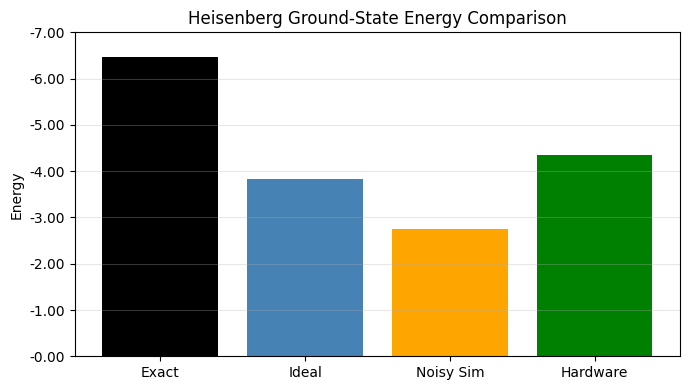

Energies:
Exact     : -6.464102
Ideal     : -3.822039
Noisy Sim : -2.757000
Hardware  : -4.359333


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

labels = ["Exact", "Ideal", "Noisy Sim", "Hardware"]
values = [E_exact, E_vqe_final_d2, E_vqe_noisy_final_d2, E_hw_mean]

plot_vals = [-v for v in values]

plt.figure(figsize=(7,4))
plt.bar(labels, plot_vals, color=["black", "steelblue", "orange", "green"])

plt.ylabel("Energy")
plt.title("Heisenberg Ground-State Energy Comparison")

yticks = plt.yticks()[0]
plt.yticks(yticks, [f"{-t:.2f}" for t in yticks])

plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

print("Energies:")
for name, val in zip(labels, values):
    print(f"{name:10s}: {val:.6f}")


## Hardware VQE result

The hardware energy coming in lower than both the ideal and noisy
simulators isn’t a “real” improvement. It reflects the limits of our
setup. With only a few evaluations, finite shots, and a single parameter
point, the hardware result can easily bounce around and land in a region
that looks better than expected. This outcome basically shows that our
sampling is too small, the estimates are noisy, and real devices vary
run-to-run, so we shouldn’t over interpret a single value. More runs and
more shots would be needed to say anything definitive.
